In [2]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

import datetime

In [3]:
%%time
trans = pd.read_parquet('./hack_data/transactions.parquet', engine='pyarrow', use_threads=True)

CPU times: user 23.4 s, sys: 32.9 s, total: 56.3 s
Wall time: 1min 7s


In [4]:
rows_number =  10 ** 7
trans_short = trans.iloc[:rows_number]
# trans_short = trans.iloc[-rows_number:]

trans_short = trans_short[['plant', 'client_id', 'chq_date', 'sales_count', 'sales_sum', 'material']]

le = preprocessing.LabelEncoder()
trans_short['client_id'] = le.fit_transform(trans_short['client_id'])
trans_short['product_id'] = le.fit_transform(trans_short['material'])
trans_short['shop_id'] = le.fit_transform(trans_short['plant'])
trans_short = trans_short.drop(columns=['material', 'plant'])

In [5]:
del trans

In [6]:
trans_short['product_id'].value_counts().index[:20].values

array([63730, 34178, 20278,  6914, 74705, 59421, 63645, 81783, 41056,
       37420, 83335, 42492, 31216, 59000, 69698, 41130,  5149,  2074,
       77897, 41103])

In [7]:
example_product_id = 34178

product_df = trans_short[trans_short['product_id'] == example_product_id][['chq_date', 'sales_count']]
product_df = product_df.sort_values(by=['chq_date'])
product_df = product_df.groupby(['chq_date'], as_index=False).sum()
product_df['day_number'] = le.fit_transform(product_df['chq_date'])


supplement_day_frequency = 28
product_df['supplement_day'] = product_df['day_number'].apply(lambda x:
                                                              int(np.remainder(x, supplement_day_frequency) == 0))



In [9]:
week_num = 2

week_df = product_df.iloc[week_num * supplement_day_frequency : (week_num + 1) * supplement_day_frequency]
week_df['cum_sum'] = np.cumsum(week_df['sales_count'])
week_df['stock_amount'] = week_df['cum_sum'].apply(lambda x: np.sum(week_df['sales_count']) - x)
week_df['stock_amount'] += np.random.randint(low=-100, high=100, size=week_df.shape[0])


week_df['stock_amount'] = week_df['stock_amount'] - np.repeat(6000, supplement_day_frequency)


week_df['stock_amount'] = week_df['stock_amount'].apply(lambda x: max(x,0))
week_df = week_df.drop(columns=['sales_count', 'supplement_day', 'cum_sum'])

In [10]:
cur_day_id = np.random.randint(low=5, high=supplement_day_frequency-1)
current_day = week_df['day_number'].values[cur_day_id]


train_dates = week_df[week_df['day_number'] <= current_day]['chq_date']
train_dates = [str(el)[:10] for el in train_dates.values]
train_stock = week_df[week_df['day_number'] <= current_day]['stock_amount'].values


test_dates = week_df[week_df['day_number'] > current_day]['chq_date']
test_dates = [str(el)[:10] for el in test_dates.values]
test_stock = week_df[week_df['day_number'] > current_day]['stock_amount'].values

# Holt’s Damped Trend

In [25]:
model = ExponentialSmoothing(train_stock, trend='mul')
fit = model.fit()
predictions = fit.forecast(supplement_day_frequency - cur_day_id - 1)

### Predictions visualization

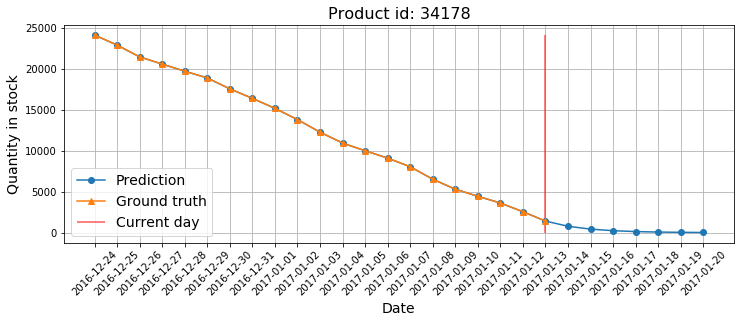

In [26]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(supplement_day_frequency),
         np.concatenate([train_stock, predictions]), label='Prediction', marker='o')

plt.plot(np.arange(train_stock.shape[0]),
         train_stock, label='Ground truth', marker='^')

plt.vlines(x=cur_day_id, ymin=0, ymax=np.max(train_stock), color='red', alpha=0.65, label='Current day')

plt.title('Product id: {}'.format(example_product_id), fontsize=16)
plt.legend(fontsize=14, loc='lower left')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Quantity in stock', fontsize=14)
plt.xticks(np.arange(supplement_day_frequency),
           np.concatenate([train_dates, test_dates]),
           rotation=45)

plt.grid()
plt.savefig('./pics/{}_stock_product_id_{}.pdf'.format(str(datetime.datetime.now())[:10],
                                                       example_product_id))
plt.show()

### to csv

In [27]:
train_df = pd.DataFrame(data=np.array([train_dates, train_stock]).T, columns=['train_date', 'quantity_in_stock'])

In [28]:
predictions_df = pd.DataFrame(data=np.array([test_dates, predictions]).T, columns=['test_date', 'predictions'])

In [29]:
train_df.to_csv('./for_excel/stock_train_product_id_{}_current_day_{}.csv'.format(example_product_id,
                                                                                  str(week_df['chq_date'].values[cur_day_id])[:10]),
                index=False)



In [30]:
predictions_df.to_csv('./for_excel/stock_prediction_product_id_{}_current_day_{}.csv'.format(example_product_id,
                                                                                  str(week_df['chq_date'].values[cur_day_id])[:10]),
                index=False)



# Widget function

In [26]:
def predict_stock_quantity(data, product_id, shop_id, current_date):
    try:
        product_df = data[(data['product_id'] == product_id) & (data['shop_id'] == shop_id)]
        product_df = product_df[['chq_date', 'sales_count']]
        product_df = product_df.sort_values(by=['chq_date'])
        product_df = product_df.groupby(['chq_date'], as_index=False).sum()
        product_df['day_number'] = le.fit_transform(product_df['chq_date'])

        np.random.seed(42)
        prev_days_num = np.random.randint(low=5, high=14)
        next_days_num = np.random.randint(low=2, high=18)

        current_day_id = product_df.loc[product_df['chq_date'] == current_date]['day_number'].values[0]
        week_df = product_df[product_df['day_number'] <= current_day_id + next_days_num]
        week_df = week_df[product_df['day_number'] > current_day_id - prev_days_num]
        week_df['cum_sum'] = np.cumsum(week_df['sales_count'])
        week_df['stock_amount'] = week_df['cum_sum'].apply(lambda x: np.sum(week_df['sales_count']) - x)
        week_df['stock_amount'] += np.random.randint(low=-100, high=100, size=week_df.shape[0])


        train_demand = week_df[week_df['chq_date'] <= current_date]['sales_count'].values[-prev_days_num:]

        model = ExponentialSmoothing(train_demand, trend='mul')
        fit = model.fit()
        predictions = fit.forecast(next_days_num)
    except:
        predictions = []
    return predictions

In [27]:
predict_stock_quantity(data=trans_short, shop_id=211, product_id=63730,
                       current_date=np.datetime64('2016-12-30'))

array([14.68422344, 12.32064082, 10.33750208,  8.67357069,  7.27746684])